In [56]:
from torch.utils.data import Dataset
from utils.data import read_csv, data_filter
from utils.constants import *
import os
import numpy as np
import pandas as pd
import numbers
from skimage import io
from transform import Rescale, RandomHorizontalFlip, RandomVerticalFlip, ToTensor, EmptyTransform
from utils.vis import show_arrow_batch, show_image_batch, show_arrow
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from dataset import PlanktonDataset

In [57]:
img_dir = '/data5/Plankton_wi18/rawcolor_db2/images'
csv_filename = '/data5/lekevin/plankton/poseprediction/poseprediction_torch/data/4/data_train_0.csv'

In [76]:
class RandomRotation(object):
    """ Rotate the image by angle """
    def __init__(self, degrees):
        self.degrees = (-degrees, degrees)
    
    def __call__(self, sample):
        angle = np.random.uniform(self.degrees[0], self.degrees[1])
        resample = False
        expand = False
        center = None

        # Rotate here
        image, coordinates, target_map = sample['image'], sample['coordinates'], sample['target_map']

        (rows,cols, _) = image.shape
        M = cv2.getRotationMatrix2D ((cols / 2, rows / 2), np.rad2deg (angle), 1)
        image = cv2.warpAffine (image, M, (cols, rows))

        copy = {key: sample[key] for key in sample}
        copy['image'], copy['coordinates'], copy['target_map'] = image, coordinates, target_map

        return copy

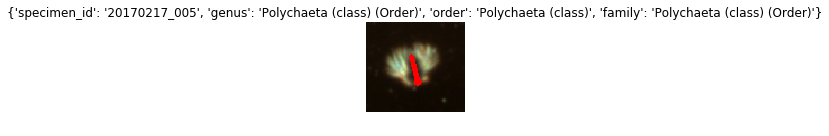

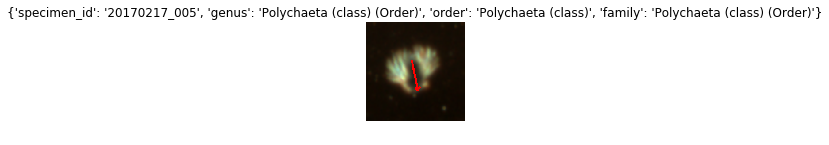

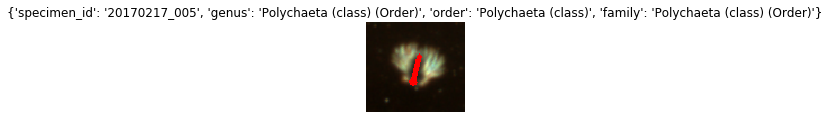

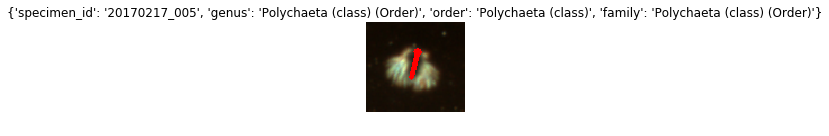

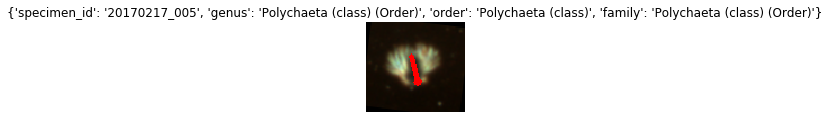

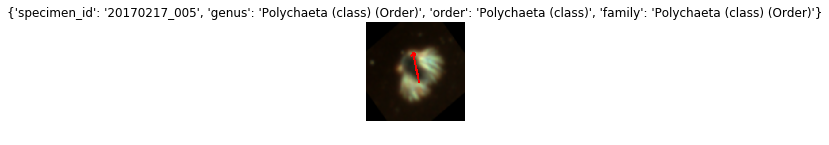

In [78]:
def test(sample, tsfms):
    original = EmptyTransform()

    n = len(tsfms) + 1
    r = int(np.sqrt(n))
    c = np.ceil(1.0 * n / r)

    for i, tsfm in enumerate([original] + tsfms):
        transformed_sample = tsfm(sample)

        ax = plt.subplot(r, c, i + 1)
        show_arrow(transformed_sample['image'], transformed_sample['coordinates'], transformed_sample['cls'])
        ax.set_title(type(tsfm).__name__)

plankton_dataset = PlanktonDataset(csv_file=csv_filename,
                                   img_dir=img_dir)
scale = Rescale((224, 224))
hflip = RandomHorizontalFlip()
vflip = RandomVerticalFlip()
rotate = RandomRotation(180)
composed = transforms.Compose([hflip, vflip, rotate, Rescale((224, 224))])

plt.figure()
test(plankton_dataset[3], [scale, hflip, vflip, rotate, composed])
plt.show()

In [85]:
transformed_dataset = PlanktonDataset(csv_file=csv_filename,
                                      img_dir=img_dir,
                                      transform=transforms.Compose([
                                          Rescale((224, 224)),
                                          RandomHorizontalFlip(),
                                          RandomVerticalFlip(),
                                            RandomRotation(180),
                                          ToTensor()
                                      ]))

In [86]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

(0, torch.Size([4, 3, 224, 224]), torch.Size([4, 4]), torch.Size([4, 3, 48, 48]), {'specimen_id': ['20170213_001', '20170216_001', '20170217_002', '20170303_005'], 'genus': ['Poecilostomatoida (Family)', 'Oithonidae (Family)', 'Acartiidae (Family)', 'Centropagidae (Family)'], 'order': ['Cyclopoida', 'Cyclopoida', 'Calanoida', 'Calanoida'], 'family': ['Poecilostomatoida', 'Oithonidae', 'Acartiidae', 'Centropagidae']})
(1, torch.Size([4, 3, 224, 224]), torch.Size([4, 4]), torch.Size([4, 3, 48, 48]), {'specimen_id': ['20170203_001', '20170224_011', '20170130_003', '20170130_003'], 'genus': ['Centropages', 'Hydromedusae (Order)', 'Brachyura (Family)', 'Brachyura (Family)'], 'order': ['Calanoida', 'Hydromedusae', 'Decapoda', 'Decapoda'], 'family': ['Centropagidae', 'Hydromedusae (Order)', 'Brachyura', 'Brachyura']})
(2, torch.Size([4, 3, 224, 224]), torch.Size([4, 4]), torch.Size([4, 3, 48, 48]), {'specimen_id': ['20170307_002', '20170306_005', '20170504_006', '20170203_001'], 'genus': ['Ac

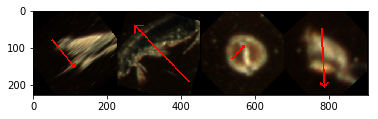

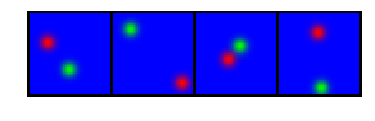

In [87]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['coordinates'].size(),
          sample_batched['target_map'].size(),
          sample_batched['cls'])

    if i_batch == 3:
        plt.figure()
        show_arrow_batch(sample_batched)
        plt.figure()
        show_image_batch(sample_batched['target_map'])
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [7]:
for data in dataloader:
    inputs, target_class, target_map, coordinates = \
        data['image'], data['class_index'], data['target_map'], data['coordinates']
    print(coordinates)
    break


 0.6773  0.5800  0.3250  0.6000
 0.7450  0.7042  0.2675  0.2324
 0.5600  0.6636  0.3100  0.3682
 0.1500  0.3457  0.5950  0.7063
[torch.DoubleTensor of size 4x4]



In [ ]:
# view each random specimen of the test set and compare with the ones in training
# loop through each dataset, pull out 